In [188]:
import re

FIG_DIR = 'img/'

CASE = {
    'small': 'n=1000, dens=0.3',
    'medium': 'n=10000, dens=0.01',
    'large': 'n=10000, dens=0.05',
}

In [189]:
class JobDesc:
    def __init__(self, case, tasks, nodes, layers, alg, job_id):
        self.case = case
        self.tasks = tasks
        self.nodes = nodes
        self.layers = layers
        self.alg = alg
        self.job_id = job_id

    def __str__(self):
        return (
            f"case: {self.case}, tasks: {self.tasks}, nodes: {self.nodes}, "
            f"layers: {self.layers}, alg: {self.alg}, job_id: {self.job_id}"
        )

    def __repr__(self):
        return f'JobDesc({self.__str__()})'

In [190]:
# Results file contains such lines. Every six lines are a group.

# >>>>>>>
# ==> matmul_large-0_t24_n6_l1_a2D-1189621.err <==
# 1719234533852 [TIME] matmul-start-timestamp
# 1719234539668 [TIME] matmul-data-distribution-done-timestamp
# 1719234542147 [TIME] matmul-algorithm-done-timestamp
# 1719234542147 [TIME] matmul-g-value-done-timestamp
# 1719234542181 [TIME] matmul-data-collection-done-timestamp
#
# ==> matmul_large-0_t24_n6_l1_a3D-1189622.err <==
# 1719234546133 [TIME] matmul-start-timestamp
# 1719234551923 [TIME] matmul-data-distribution-done-timestamp
# 1719234554766 [TIME] matmul-algorithm-done-timestamp
# 1719234554766 [TIME] matmul-g-value-done-timestamp
# 1719234554855 [TIME] matmul-data-collection-done-timestamp
# ....


# This should accept six lines, but labels are not sorted
JOB_RESULT_RE = re.compile(
    r"==> matmul_(\w+)-(\d+)_t(\d+)_n(\d+)_l(\d+)_a(\w+)-(\d+).err <==\n"
    r"(\d+) \[TIME\] ([\w-]+)\n"
    r"(\d+) \[TIME\] ([\w-]+)\n"
    r"(\d+) \[TIME\] ([\w-]+)\n"
    r"(\d+) \[TIME\] ([\w-]+)\n"
    r"(\d+) \[TIME\] ([\w-]+)\n"
)

class JobResult:
    def __init__(self, timestamp_in_millis, labels):
        self.timestamp_in_millis = timestamp_in_millis
        self.labels = labels

    def __str__(self):
        return f"timestamp: {self.timestamp_in_millis}, labels: {self.labels}"

    def __repr__(self):
        return f'JobResult({self.__str__()})'


def parse_job_result(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    job_results = []
    for i in range(0, len(lines), 7):
        job_result = JOB_RESULT_RE.match(
            lines[i] + lines[i + 1] + lines[i + 2] + lines[i + 3] + lines[i + 4] + lines[i + 5]
        )
        if job_result:
            job_desc = JobDesc(
                job_result.group(1),
                int(job_result.group(3)),
                int(job_result.group(4)),
                int(job_result.group(5)),
                job_result.group(6),
                int(job_result.group(7)),
            )
            for j in range(8, 18, 2):
                job_results.append((job_desc, JobResult(int(job_result.group(j)), job_result.group(j + 1))))
        else:
            print("Error: Could not parse job result: ", lines[i], lines[i + 1], lines[i + 2], lines[i + 3], lines[i + 4], lines[i + 5])

    return job_results


In [191]:
results = parse_job_result("results.txt")

In [192]:
results

[(JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 2D, job_id: 1189924),
  JobResult(timestamp: 1719264965554, labels: matmul-start-timestamp)),
 (JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 2D, job_id: 1189924),
  JobResult(timestamp: 1719264971317, labels: matmul-data-distribution-done-timestamp)),
 (JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 2D, job_id: 1189924),
  JobResult(timestamp: 1719264975001, labels: matmul-algorithm-done-timestamp)),
 (JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 2D, job_id: 1189924),
  JobResult(timestamp: 1719264975001, labels: matmul-g-value-done-timestamp)),
 (JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 2D, job_id: 1189924),
  JobResult(timestamp: 1719264975028, labels: matmul-data-collection-done-timestamp)),
 (JobDesc(case: large, tasks: 12, nodes: 3, layers: 1, alg: 3D, job_id: 1189925),
  JobResult(timestamp: 1719264998061, labels: matmul-start-timestamp)),
 (JobDesc(case: large, tasks

In [193]:
import pandas as pd

In [194]:
raw_df = pd.DataFrame(results, columns=["job_desc", "job_result"])

In [195]:
# Break structs into columns

df_full = raw_df.apply(lambda x: (pd.Series(x["job_desc"].__dict__ | x["job_result"].__dict__)), axis=1)

In [196]:
df_full

,case,tasks,nodes,layers,alg,job_id,timestamp_in_millis,labels
0,large,12,3,1,2D,1189924,1719264965554,matmul-start-timestamp
1,large,12,3,1,2D,1189924,1719264971317,matmul-data-distribution-done-timestamp
2,large,12,3,1,2D,1189924,1719264975001,matmul-algorithm-done-timestamp
3,large,12,3,1,2D,1189924,1719264975001,matmul-g-value-done-timestamp
4,large,12,3,1,2D,1189924,1719264975028,matmul-data-collection-done-timestamp
...,...,...,...,...,...,...,...,...
235,small,9,1,1,3D,1189892,1719263903231,matmul-start-timestamp
236,small,9,1,1,3D,1189892,1719263903576,matmul-data-distribution-done-timestamp
237,small,9,1,1,3D,1189892,1719263903803,matmul-algorithm-done-timestamp
238,small,9,1,1,3D,1189892,1719263903803,matmul-g-value-done-timestamp


In [197]:
df_desc = df_full.drop(columns=["timestamp_in_millis", "labels"])
df_desc.set_index("job_id", inplace=True)
df_desc.drop_duplicates(inplace=True)
df_desc

,case,tasks,nodes,layers,alg
job_id,,,,,
1189924,large,12,3,1,2D
1189925,large,12,3,1,3D
1189922,large,16,1,1,2D
1189923,large,16,1,1,3D
1189947,large,1,1,1,2D
1189948,large,1,1,1,3D
1189926,large,24,6,1,2D
1189928,large,24,6,1,3D
1189929,large,24,6,4,2D


In [198]:
# I need DF with columns: job_id, {all labels}. Values are timestamps.

# First, I need to pivot the DF

df = df_full.pivot(index="job_id", columns="labels", values="timestamp_in_millis")

In [199]:
df

labels,matmul-algorithm-done-timestamp,matmul-data-collection-done-timestamp,matmul-data-distribution-done-timestamp,matmul-g-value-done-timestamp,matmul-start-timestamp
job_id,,,,,
1189889,1719263873857,1719263873860,1719263873518,1719263873857,1719263873118
1189890,1719263883957,1719263883962,1719263883528,1719263883957,1719263883186
1189891,1719263893713,1719263893716,1719263893535,1719263893713,1719263893187
1189892,1719263903803,1719263903809,1719263903576,1719263903803,1719263903231
1189893,1719263913787,1719263913805,1719263913653,1719263913787,1719263913304
1189894,1719263924001,1719263924032,1719263923847,1719263924001,1719263923364
1189895,1719263936296,1719263936297,1719263936250,1719263936296,1719263935888
1189896,1719263946393,1719263946394,1719263946338,1719263946393,1719263945975
1189897,1719263956455,1719263956455,1719263956424,1719263956455,1719263956041


In [200]:
df['total-time-ms'] = df['matmul-data-collection-done-timestamp'] - df['matmul-start-timestamp']
df['distribution-time-ms'] = df['matmul-data-distribution-done-timestamp'] - df['matmul-start-timestamp']
df['algorithm-time-ms'] = df['matmul-algorithm-done-timestamp'] - df['matmul-data-distribution-done-timestamp']
df['g-value-time-ms'] = df['matmul-g-value-done-timestamp'] - df['matmul-algorithm-done-timestamp']
df['collection-time-ms'] = df['matmul-data-collection-done-timestamp'] - df['matmul-g-value-done-timestamp']

In [201]:
df

labels,matmul-algorithm-done-timestamp,matmul-data-collection-done-timestamp,matmul-data-distribution-done-timestamp,matmul-g-value-done-timestamp,matmul-start-timestamp,total-time-ms,distribution-time-ms,algorithm-time-ms,g-value-time-ms,collection-time-ms
job_id,,,,,,,,,,
1189889,1719263873857,1719263873860,1719263873518,1719263873857,1719263873118,742,400,339,0,3
1189890,1719263883957,1719263883962,1719263883528,1719263883957,1719263883186,776,342,429,0,5
1189891,1719263893713,1719263893716,1719263893535,1719263893713,1719263893187,529,348,178,0,3
1189892,1719263903803,1719263903809,1719263903576,1719263903803,1719263903231,578,345,227,0,6
1189893,1719263913787,1719263913805,1719263913653,1719263913787,1719263913304,501,349,134,0,18
1189894,1719263924001,1719263924032,1719263923847,1719263924001,1719263923364,668,483,154,0,31
1189895,1719263936296,1719263936297,1719263936250,1719263936296,1719263935888,409,362,46,0,1
1189896,1719263946393,1719263946394,1719263946338,1719263946393,1719263945975,419,363,55,0,1
1189897,1719263956455,1719263956455,1719263956424,1719263956455,1719263956041,414,383,31,0,0


In [202]:
df = df.drop(columns=['matmul-start-timestamp', 'matmul-data-distribution-done-timestamp', 'matmul-algorithm-done-timestamp', 'matmul-g-value-done-timestamp', 'matmul-data-collection-done-timestamp'])

In [203]:
# add job description columns
df = df.join(df_desc[['case', 'tasks', 'nodes', 'layers', 'alg']], on='job_id')

In [204]:
df['proc-count'] = df['tasks'] * df['nodes']
df.drop(columns=['tasks', 'nodes'], inplace=True)
df.reset_index(inplace=True)
df

,job_id,total-time-ms,distribution-time-ms,algorithm-time-ms,g-value-time-ms,collection-time-ms,case,layers,alg,proc-count
0,1189889,742,400,339,0,3,small,1,2D,4
1,1189890,776,342,429,0,5,small,1,3D,4
2,1189891,529,348,178,0,3,small,1,2D,9
3,1189892,578,345,227,0,6,small,1,3D,9
4,1189893,501,349,134,0,18,small,1,2D,16
5,1189894,668,483,154,0,31,small,1,3D,16
6,1189895,409,362,46,0,1,small,1,2D,36
7,1189896,419,363,55,0,1,small,1,3D,36
8,1189897,414,383,31,0,0,small,1,2D,144
9,1189899,414,383,30,0,1,small,1,3D,144


In [205]:
import matplotlib.pyplot as plt

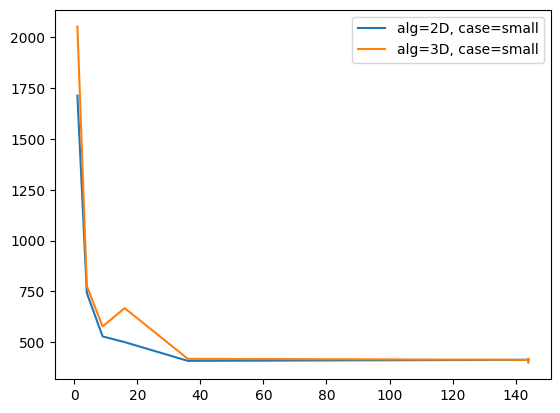

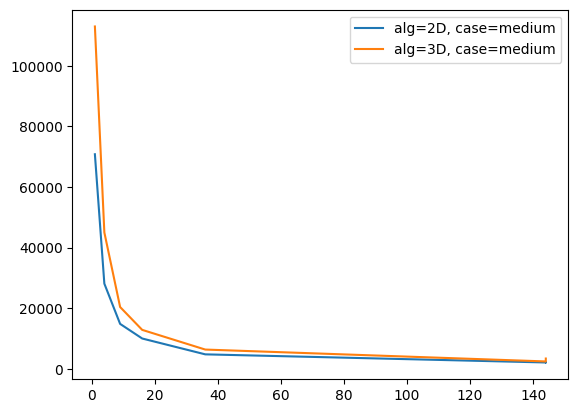

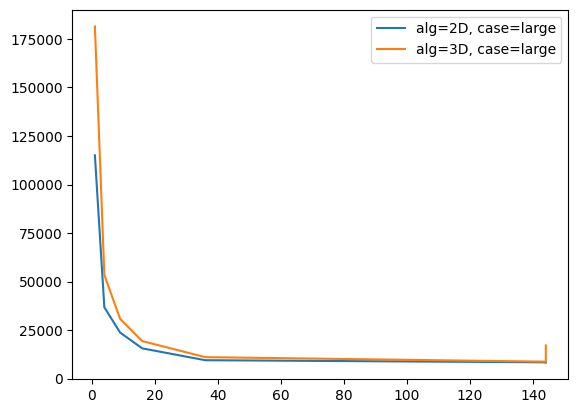

In [206]:
ALGORITHMS = ['2D', '3D']
CASES = ['small', 'medium', 'large']

plt.figure()
for case in CASES:
    for alg in ALGORITHMS:
        df_alg = df[(df['alg'] == alg) & (df['case'] == case)].sort_values('proc-count')
        plt.plot(df_alg['proc-count'], df_alg['total-time-ms'], label=f'alg={alg}, case={case}')
        plt.legend()
    plt.show()


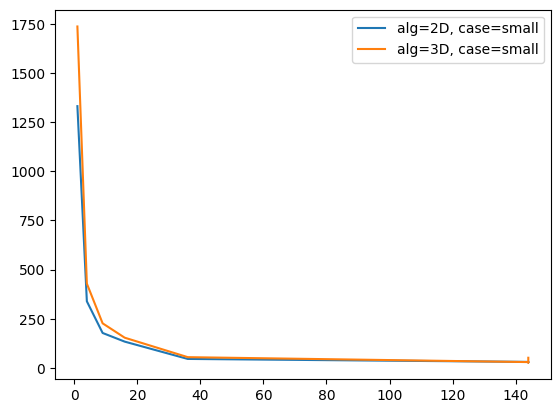

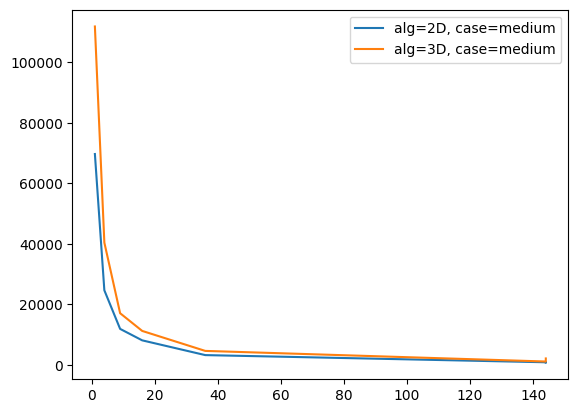

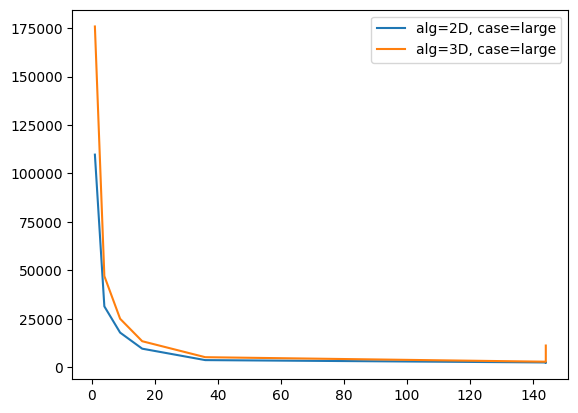

In [207]:
plt.figure()
for case in CASES:
    for alg in ALGORITHMS:
        df_alg = df[(df['alg'] == alg) & (df['case'] == case)].sort_values('proc-count')
        plt.plot(df_alg['proc-count'], df_alg['algorithm-time-ms'], label=f'alg={alg}, case={case}')
        plt.legend()
    plt.show()

In [208]:

def plot_speedup(label_type):
    df_speedup = df.join(df[df['proc-count'] == 1][['case', 'alg', label_type]].set_index(['case', 'alg']), on=['case', 'alg'], rsuffix='_1')
    df_speedup['speedup'] = df_speedup[label_type + '_1'] / df_speedup[label_type]

    def readable(label_type):
        if label_type == 'total-time-ms':
            return 'Total time'
        elif label_type == 'distribution-time-ms':
            return 'Distribution time'
        elif label_type == 'algorithm-time-ms':
            return 'Algorithm time'
        elif label_type == 'g-value-time-ms':
            return 'G-value time'
        elif label_type == 'collection-time-ms':
            return 'Collection time'
        else:
            return label_type

    for case in CASES:
        plt.title(f'{readable(label_type)} speedup for case: {CASE[case]}')
        for algo in ALGORITHMS:
            df_speedup_case = df_speedup[(df_speedup['alg'] == algo) & (df_speedup['case'] == case)]
            df_sorted_by_proc_count = df_speedup_case.sort_values('proc-count')
            df_project_to_proc_count = df_sorted_by_proc_count[['proc-count', 'speedup']]
            df_project_to_proc_count_mean = df_project_to_proc_count.groupby('proc-count').mean()
            df_project_to_proc_count_mean.reset_index(inplace=True)
            plt.plot(df_project_to_proc_count_mean['proc-count'], df_project_to_proc_count_mean['speedup'], label=f'Algorythm: {algo}')
            plt.legend()
        min_x = df_speedup_case['proc-count'].min()
        max_x = df_speedup_case['proc-count'].max()
        plt.plot([min_x, max_x], [min_x, max_x], label='Ideal speedup', linestyle='dashed')
        plt.legend()
        plt.savefig(f'{FIG_DIR}/{label_type}_speedup_{case}.png')
        plt.show()


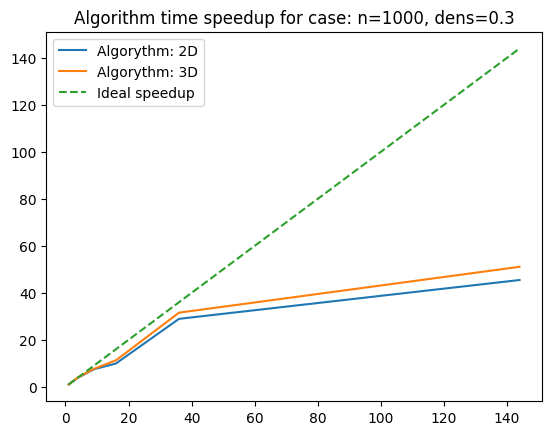

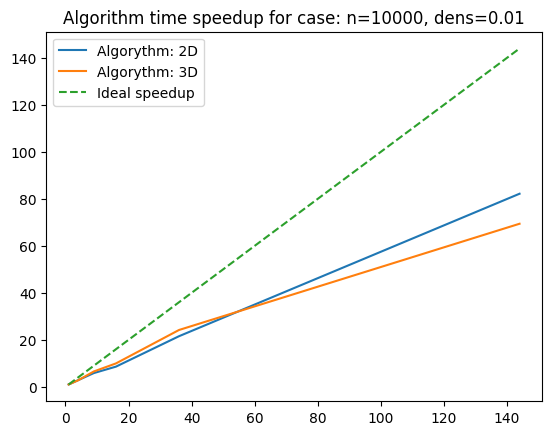

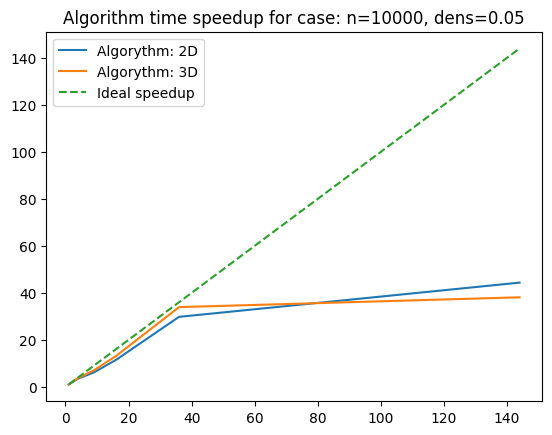

In [209]:
plot_speedup('algorithm-time-ms')

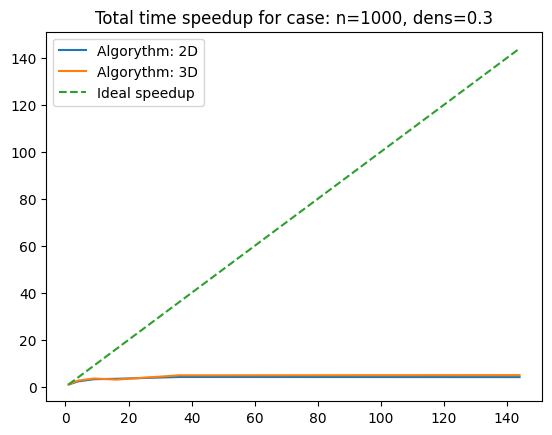

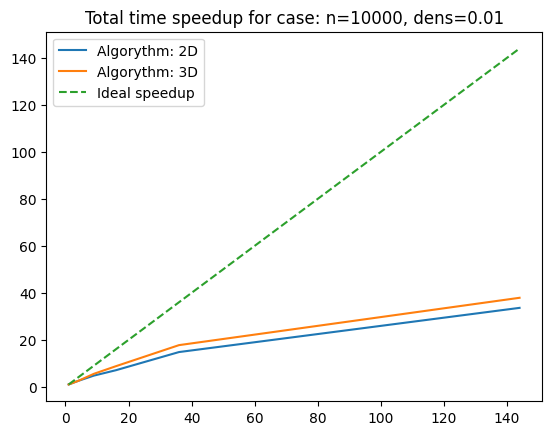

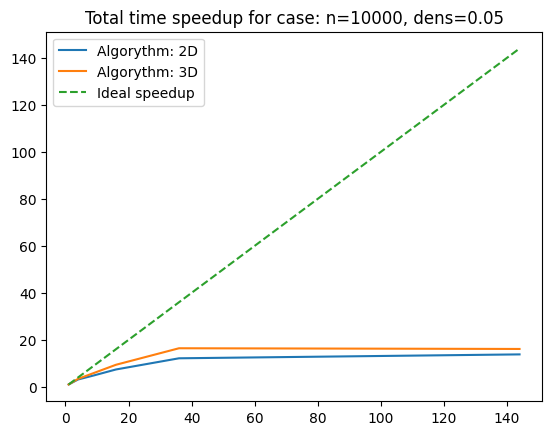

In [210]:
plot_speedup('total-time-ms')